In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

from captum.attr import IntegratedGradients, Saliency
from transformers import ViTForImageClassification



In [ ]:
Загрузим предобученную модель

In [3]:
device = torch.device('cpu')
model_name_or_path = '../saved_model'
model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path=model_name_or_path,
    num_labels=2
).to(device)
model.eval()


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [4]:
import sys
import os

project_root = 'D:\\pythonProjects\\AIRetailVision\\src'
sys.path.append(project_root)

In [5]:
from custom_dataset import CustomDataset
import json

with open('../src/config.json', 'r') as f:
    config = json.load(f)

In [16]:
test_dataset = CustomDataset(
    root_dir=config['testing_data']['path_orig_test']
)

adversarial_test_dataset = CustomDataset(
    root_dir=config['testing_data']['path_pgd_test']
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1
)

adversarial_test_dataloader = DataLoader(
    dataset=adversarial_test_dataset,
    batch_size=1
)

In [27]:
def show_integrated_gradients_dual(
    model: torch.nn.Module,
    original_dataloader: DataLoader,
    attacked_dataloader: DataLoader,
    count_show: int = 1,
    indices: list = None,  # список индексов примеров для показа; если None — берутся первые count_show примеров
    device: torch.device = torch.device("cuda")
) -> None:
    """
    param: model: обученная модель
    param: original_dataloader: DataLoader с оригинальными изображениями (ключи: 'pixel_values', 'labels')
    param: attacked_dataloader: DataLoader с атакованными изображениями (ключи: 'pixel_values', 'labels')
    param: count_show: сколько примеров показать
    param: indices: список индексов примеров, которые необходимо показать
    param: device: устройство для вычислений (cpu или cuda)
    """
    # Обёртка для работы Captum (возвращает logits)
    def custom_forward(inputs):
        return model(inputs).logits

    ig = IntegratedGradients(custom_forward)
    shown = 0
    model.to(device)
    model.eval()
    # Итерация по парам батчей (оригинальный и атакованный)
    for idx, (batch_orig, batch_att) in enumerate(zip(original_dataloader, attacked_dataloader)):
        # Если заданы конкретные индексы, пропускаем не нужные
        if indices is not None and idx not in indices:
            continue

        # Обработка оригинального изображения
        inputs_orig = batch_orig['pixel_values'].to(device)
        target_orig = batch_orig['labels'].to(device)
        inputs_orig = inputs_orig.requires_grad_()
        baseline_orig = torch.zeros_like(inputs_orig)
        attributions_orig, delta_orig = ig.attribute(
            inputs_orig, baselines=baseline_orig, target=target_orig.item(), return_convergence_delta=True
        )
        attributions_orig = attributions_orig.squeeze().cpu().detach().numpy()
        img_orig = inputs_orig.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
        prediction_orig = model(inputs_orig).logits.argmax(dim=1).item()
        
        # Обработка атакованного изображения
        inputs_att = batch_att['pixel_values'].to(device)
        target_att = batch_att['labels'].to(device)
        inputs_att = inputs_att.requires_grad_()
        baseline_att = torch.zeros_like(inputs_att)
        attributions_att, delta_att = ig.attribute(
            inputs_att, baselines=baseline_att, target=target_att.item(), return_convergence_delta=True
        )
        attributions_att = attributions_att.squeeze().cpu().detach().numpy()
        img_att = inputs_att.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
        prediction_att = model(inputs_att).logits.argmax(dim=1).item()

        # Визуализация: два ряда, в первом - оригинал, во втором - атака
        plt.figure(figsize=(16, 8))
        
        # Оригинальное изображение
        plt.subplot(2, 3, 1)
        plt.title("Оригинал: Изображение")
        plt.imshow(img_orig)
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.title("Оригинал: Атрибуции IG")
        plt.imshow(np.sum(np.abs(attributions_orig), axis=0), cmap='hot')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.title("Оригинал: Предсказание")
        plt.text(0.5, 0.5, f'Правильный: {target_orig.item()}\nПредсказанный: {prediction_orig}',
                 fontsize=16, ha='center', va='center')
        plt.axis('off')
        
        # Атакованное изображение
        plt.subplot(2, 3, 4)
        plt.title("Атака: Изображение")
        plt.imshow(img_att)
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.title("Атака: Атрибуции IG")
        plt.imshow(np.sum(np.abs(attributions_att), axis=0), cmap='hot')
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.title("Атака: Предсказание")
        plt.text(0.5, 0.5, f'Правильный: {target_att.item()}\nПредсказанный: {prediction_att}',
                 fontsize=16, ha='center', va='center')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        shown += 1
        if shown == count_show:
            break


In [41]:
import random
count_show = 5
indices = []
for _ in range(count_show):
    indices.append(random.randint(0,len(test_dataloader.dataset)))
print(indices)

[138, 46, 102, 1, 411]


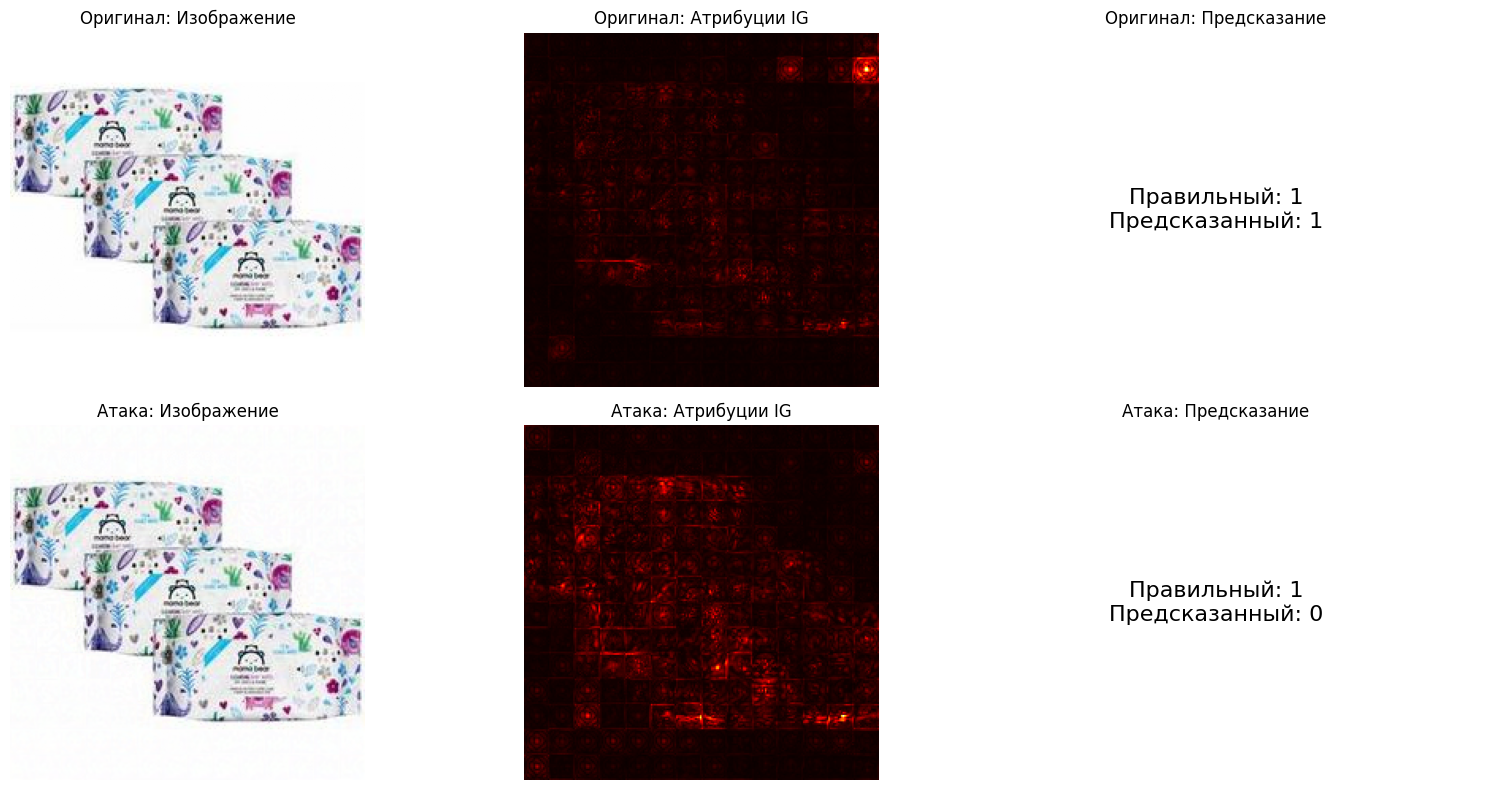

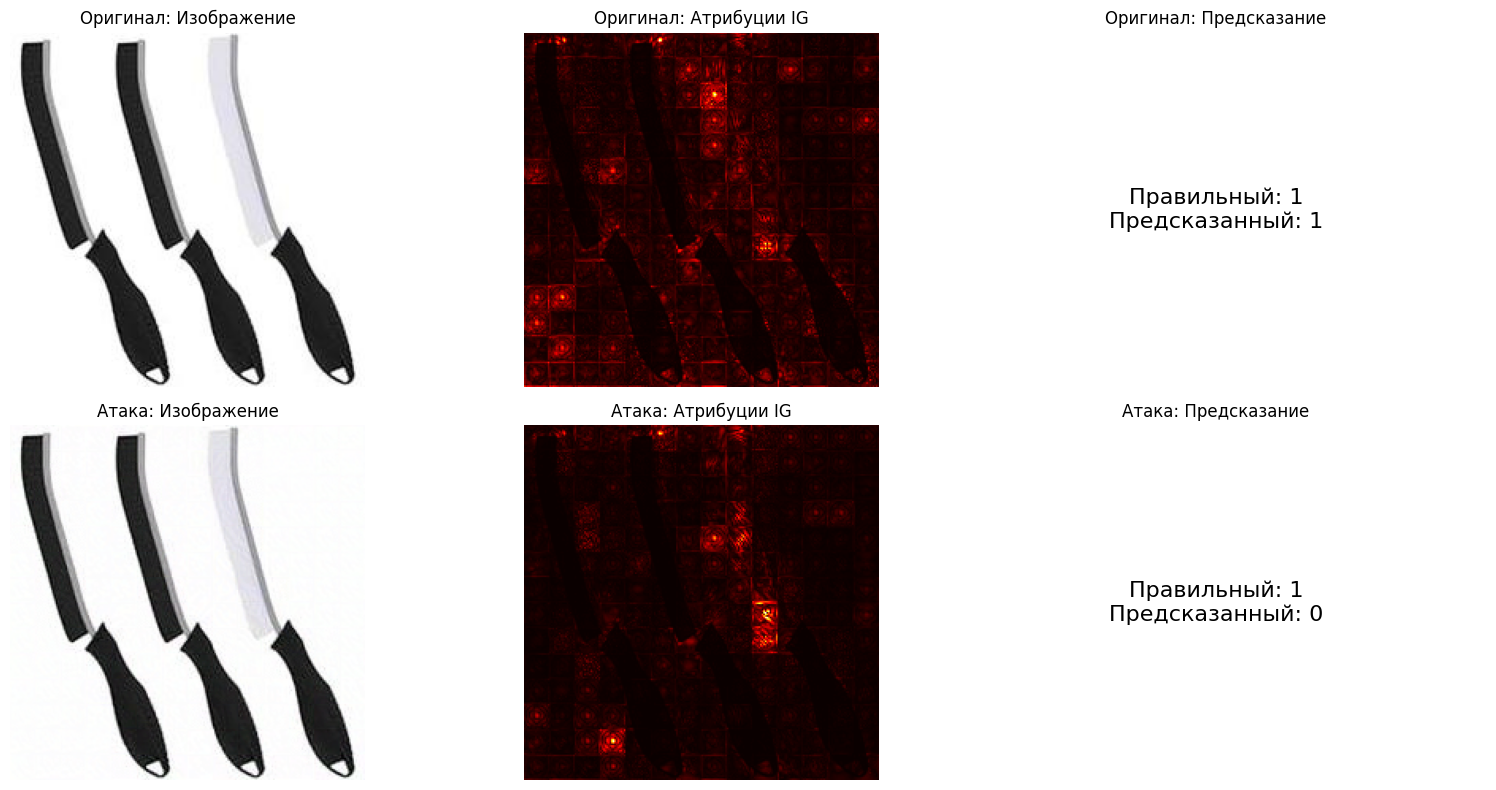

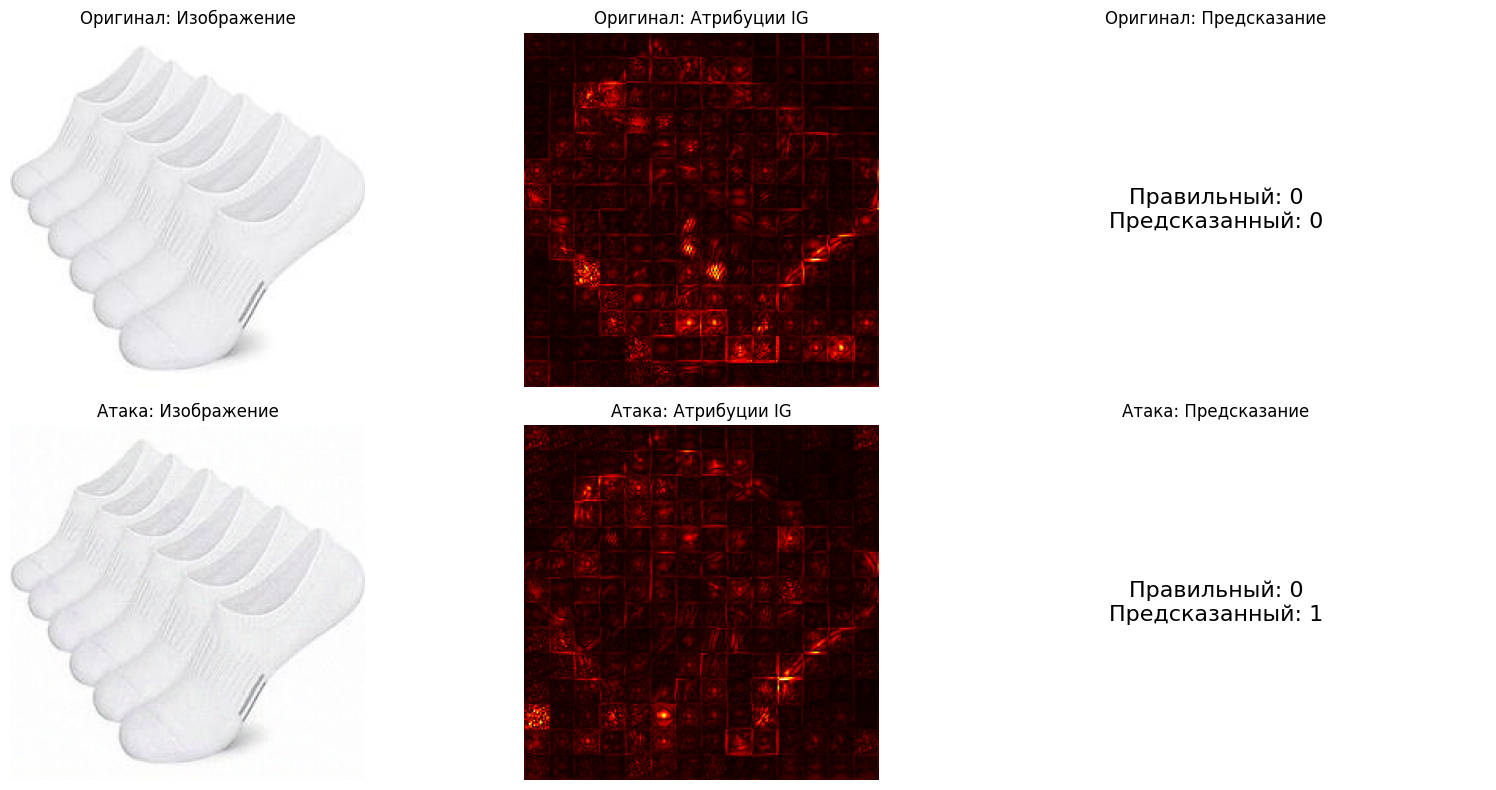

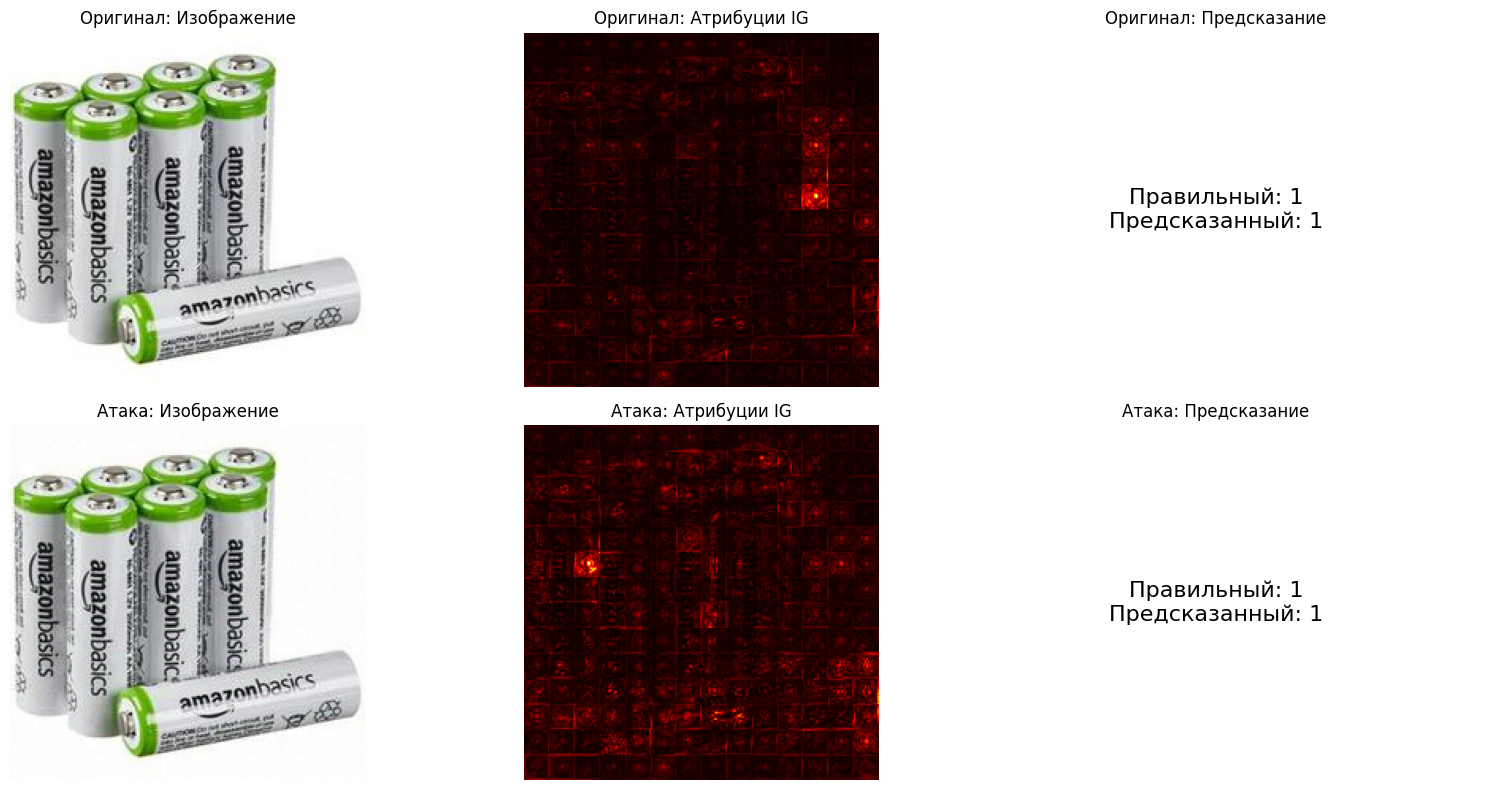

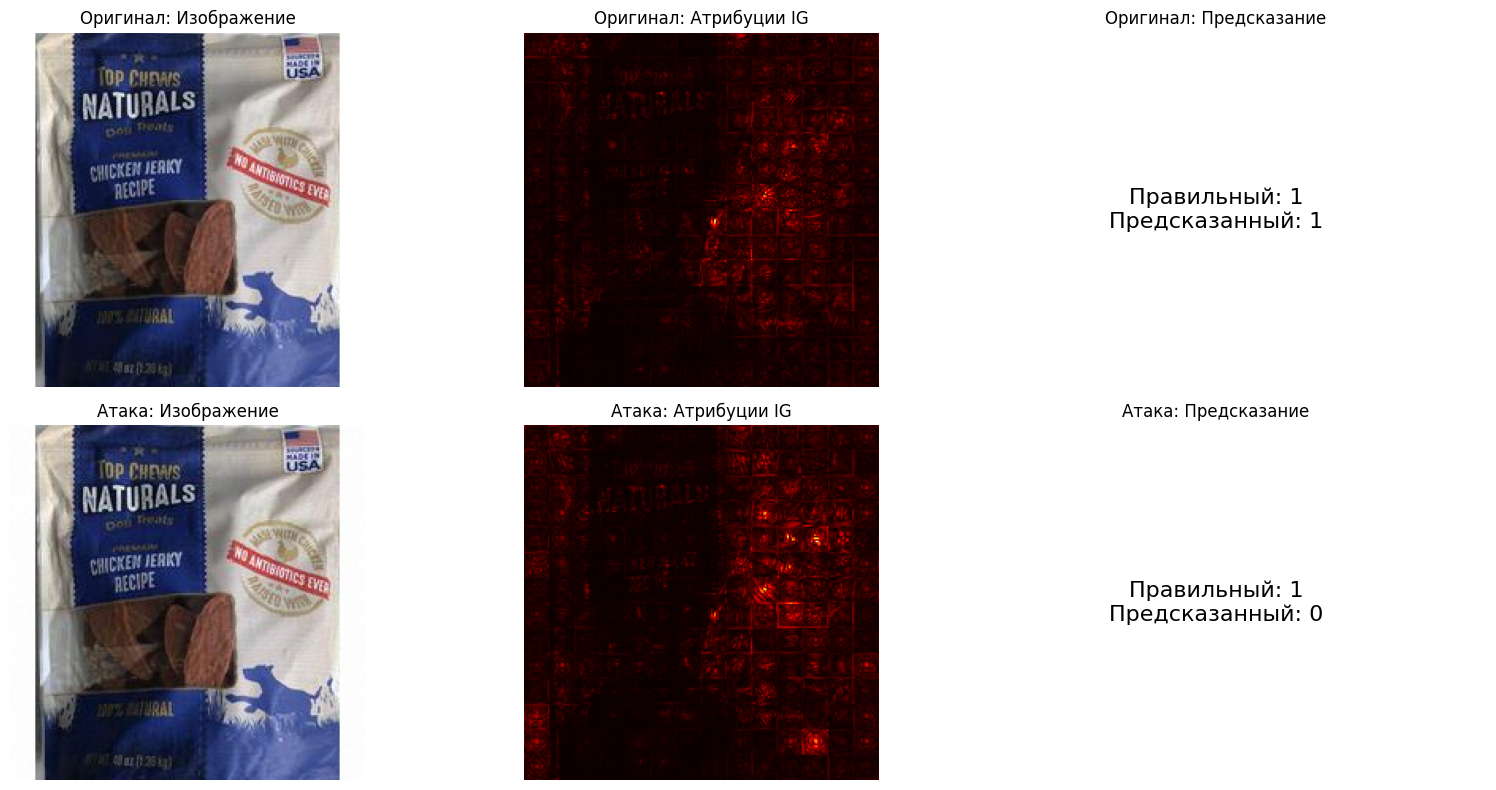

In [42]:
show_integrated_gradients_dual(
    model=model,
    original_dataloader=test_dataloader,
    attacked_dataloader=adversarial_test_dataloader,
    count_show=count_show,
    indices=indices
)